In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk




In [2]:
# Seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# The dataset
dataset = load_dataset("DFKI-SLT/few-nerd", "supervised")

# Filter for sentences with 'fine_ner_tags' == 24 (mountains)
def filter_mountain_sentences(data):
    return [item for item in data if 24 in item['fine_ner_tags']]

# Filter for sentences without 'fine_ner_tags' == 24 (non-mountains)
def filter_non_mountain_sentences(data):
    return [item for item in data if 24 not in item['fine_ner_tags']]

# Apply filters to the train, validation, and test sets
mountain_train = filter_mountain_sentences(dataset['train'])
mountain_val = filter_mountain_sentences(dataset['validation'])
mountain_test = filter_mountain_sentences(dataset['test'])

non_mountain_train = filter_non_mountain_sentences(dataset['train'])
non_mountain_val = filter_non_mountain_sentences(dataset['validation'])
non_mountain_test = filter_non_mountain_sentences(dataset['test'])



0000.parquet:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/131767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18824 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/37648 [00:00<?, ? examples/s]

In [3]:
# Sample 20% non-mountain sentences based on the number of mountain sentences
def sample_non_mountain_sentences(non_mountain_data, mountain_data, ratio=0.2, seed=42):
    # seed for reproducibility
    random.seed(seed)
    
    sample_size = int(len(mountain_data) * ratio)
    return random.sample(non_mountain_data, min(sample_size, len(non_mountain_data)))

# Sample non-mountain sentences (20% of the mountain sentences)
non_mountain_train_sample = sample_non_mountain_sentences(non_mountain_train, mountain_train, ratio=0.2, seed=RANDOM_SEED)
non_mountain_val_sample = sample_non_mountain_sentences(non_mountain_val, mountain_val, ratio=0.2, seed=RANDOM_SEED)
non_mountain_test_sample = sample_non_mountain_sentences(non_mountain_test, mountain_test, ratio=0.2, seed=RANDOM_SEED)

# Combine the sampled non-mountain sentences with mountain sentences
final_train = mountain_train + non_mountain_train_sample
final_val = mountain_val + non_mountain_val_sample
final_test = mountain_test + non_mountain_test_sample

# Shuffle the final datasets (with locked random seed)
random.seed(RANDOM_SEED)
random.shuffle(final_train)
random.shuffle(final_val)
random.shuffle(final_test)

# Convert the final datasets to pandas DataFrames for easy manipulation
final_train_df = pd.DataFrame(final_train)
final_val_df = pd.DataFrame(final_val)
final_test_df = pd.DataFrame(final_test)

# basic statistics of the final datasets
print(f"Final Train Stats: Sentences = {len(final_train_df)}")
print(f"Final Validation Stats: Sentences = {len(final_val_df)}")
print(f"Final Test Stats: Sentences = {len(final_test_df)}")



Final Train Stats: Sentences = 1802
Final Validation Stats: Sentences = 261
Final Test Stats: Sentences = 537


# Statistics and visualizations

In [4]:
# Basic statistics about the number of tokens and mountains per sentence
def sentence_length_stats(dataset_df, entity_tag=24):
    token_lengths = dataset_df['tokens'].apply(len)
    mountain_counts = dataset_df['fine_ner_tags'].apply(lambda tags: sum(1 for tag in tags if tag == entity_tag))
    
    return token_lengths, mountain_counts

# Histograms for token length and mountain entity count per sentence
def plot_histograms(token_lengths, mountain_counts, title_prefix="Train"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Token length histogram
    axs[0].hist(token_lengths, bins=30, color='blue', alpha=0.7)
    axs[0].set_title(f'{title_prefix} Set: Token Length Distribution')
    axs[0].set_xlabel('Number of Tokens')
    axs[0].set_ylabel('Frequency')

    # Mountain entity count histogram
    axs[1].hist(mountain_counts, bins=30, color='green', alpha=0.7)
    axs[1].set_title(f'{title_prefix} Set: Mountain Entity Count Distribution')
    axs[1].set_xlabel('Number of Mountain Entities')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()



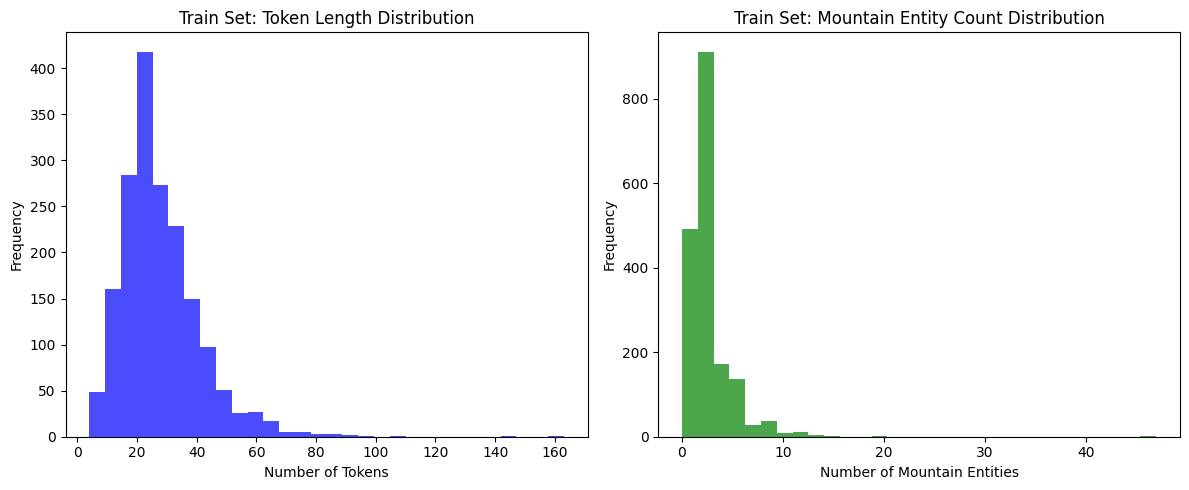

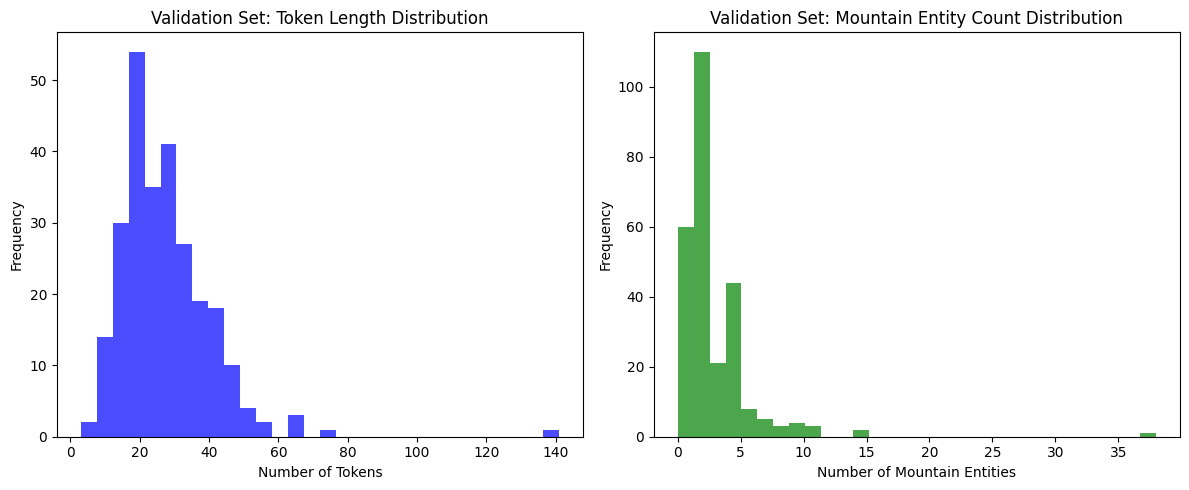

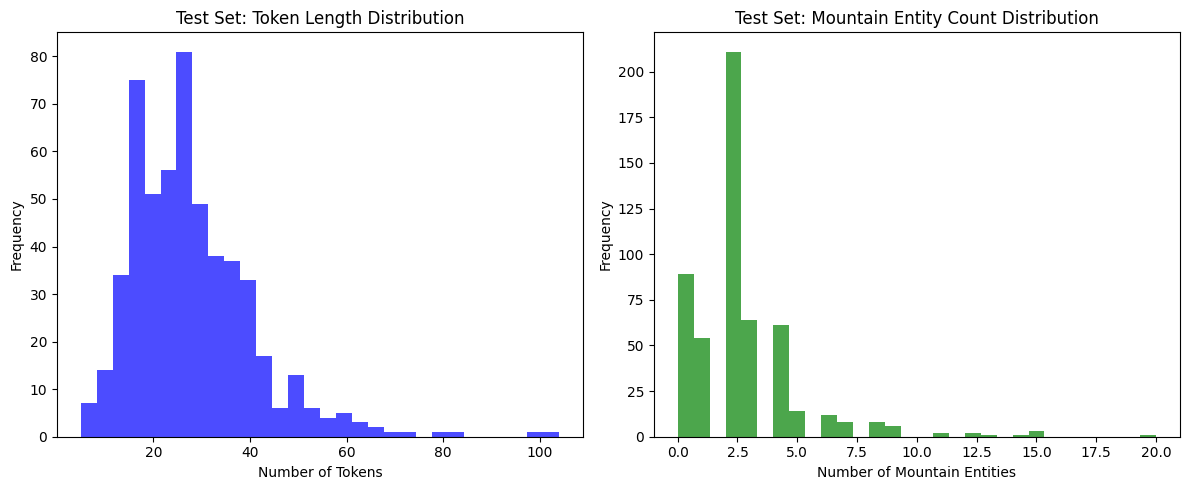

In [5]:
# Calculate and visualize stats for train, validation, and test sets
train_token_lengths, train_mountain_counts = sentence_length_stats(final_train_df)
val_token_lengths, val_mountain_counts = sentence_length_stats(final_val_df)
test_token_lengths, test_mountain_counts = sentence_length_stats(final_test_df)

# Plot histograms for Train, Validation, and Test
plot_histograms(train_token_lengths, train_mountain_counts, title_prefix="Train")
plot_histograms(val_token_lengths, val_mountain_counts, title_prefix="Validation")
plot_histograms(test_token_lengths, test_mountain_counts, title_prefix="Test")



#### Distributions of our sets are almost same, that will be good for our classification

In [6]:
# Summary statistics (mean, std) for token lengths and mountain counts
train_summary = {
    'Token Length Mean': train_token_lengths.mean(),
    'Token Length Std': train_token_lengths.std(),
    'Mountain Entity Mean': train_mountain_counts.mean(),
    'Mountain Entity Std': train_mountain_counts.std()
}

val_summary = {
    'Token Length Mean': val_token_lengths.mean(),
    'Token Length Std': val_token_lengths.std(),
    'Mountain Entity Mean': val_mountain_counts.mean(),
    'Mountain Entity Std': val_mountain_counts.std()
}

test_summary = {
    'Token Length Mean': test_token_lengths.mean(),
    'Token Length Std': test_token_lengths.std(),
    'Mountain Entity Mean': test_mountain_counts.mean(),
    'Mountain Entity Std': test_mountain_counts.std()
}

train_summary, val_summary, test_summary

({'Token Length Mean': 27.926193118756938,
  'Token Length Std': 13.577203999849264,
  'Mountain Entity Mean': 2.497225305216426,
  'Mountain Entity Std': 2.4065529323898676},
 {'Token Length Mean': 27.379310344827587,
  'Token Length Std': 13.603654525370134,
  'Mountain Entity Mean': 2.8122605363984676,
  'Mountain Entity Std': 3.2449966020389494},
 {'Token Length Mean': 27.925512104283055,
  'Token Length Std': 12.796558282928238,
  'Mountain Entity Mean': 2.543761638733706,
  'Mountain Entity Std': 2.411578724213229})

In [7]:
# The total number of mountain entities, distinct mountain entities, and samples with/without mountains
def count_mountain_stats(dataset_df, entity_tag=24):
    
    # Flatten all tokens from the dataset to count mountains
    all_tokens = [token for tokens in dataset_df['tokens'] for token in tokens]
    all_mountains = [token for tokens, tags in zip(dataset_df['tokens'], dataset_df['fine_ner_tags']) for token, tag in zip(tokens, tags) if tag == entity_tag]

    # Count distinct mountain names
    distinct_mountains = set(all_mountains)

    # Count samples with mountains and without mountains
    samples_with_mountains = len(dataset_df[dataset_df['fine_ner_tags'].apply(lambda tags: entity_tag in tags)])
    samples_without_mountains = len(dataset_df) - samples_with_mountains

    return {
        'Total mountains amount': len(all_mountains),
        'Distinct mountains amount': len(distinct_mountains),
        'Sentences with mountains': samples_with_mountains,
        'Sentences without mountains': samples_without_mountains
    }

train_mountain_stats = count_mountain_stats(final_train_df)
val_mountain_stats = count_mountain_stats(final_val_df)
test_mountain_stats = count_mountain_stats(final_test_df)

print("Train Mountain Stats:", train_mountain_stats)
print("Validation Mountain Stats:", val_mountain_stats)
print("Test Mountain Stats:", test_mountain_stats)

Train Mountain Stats: {'Total mountains amount': 4500, 'Distinct mountains amount': 1871, 'Sentences with mountains': 1502, 'Sentences without mountains': 300}
Validation Mountain Stats: {'Total mountains amount': 734, 'Distinct mountains amount': 474, 'Sentences with mountains': 218, 'Sentences without mountains': 43}
Test Mountain Stats: {'Total mountains amount': 1366, 'Distinct mountains amount': 776, 'Sentences with mountains': 448, 'Sentences without mountains': 89}


In [8]:
final_train_df.head(2)

,id,tokens,ner_tags,fine_ner_tags
0,120971,"[Siberian, tigers, share, habitat, with, Amur,...","[6, 6, 0, 0, 0, 6, 6, 0, 0, 0, 0, 4, 4, 0, 0, ...","[48, 48, 0, 0, 0, 48, 48, 0, 0, 0, 0, 24, 24, ..."
1,91034,"[Brigadier, General, Churchill, was, placed, i...","[0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, ...","[0, 0, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 3..."


In [9]:
# Drop the 'ner_tags' column as it's not needed
final_train_df = final_train_df.drop(columns=['ner_tags'])
final_val_df = final_val_df.drop(columns=['ner_tags'])
final_test_df = final_test_df.drop(columns=['ner_tags'])

# Replace all values in 'fine_ner_tags' that are not 24 with 0
def filter_mountains_only(dataset_df):
    dataset_df['fine_ner_tags'] = dataset_df['fine_ner_tags'].apply(lambda tags: [24 if tag == 24 else 0 for tag in tags])
    return dataset_df

# Apply this transformation to the train, validation, and test sets
final_train_df = filter_mountains_only(final_train_df)
final_val_df = filter_mountains_only(final_val_df)
final_test_df = filter_mountains_only(final_test_df)

# Now, the 'fine_ner_tags' will only have 24 for mountains and 0 for everything else
final_train_df.head(2) 

,id,tokens,fine_ner_tags
0,120971,"[Siberian, tigers, share, habitat, with, Amur,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 0, 0..."
1,91034,"[Brigadier, General, Churchill, was, placed, i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
# Inspect the original fine_ner_tags for the first row before transformation
print(final_train[0]) 

{'id': '120971', 'tokens': ['Siberian', 'tigers', 'share', 'habitat', 'with', 'Amur', 'leopards', ',', 'but', 'in', 'the', 'Changbai', 'Mountains', 'have', 'been', 'recorded', 'more', 'often', 'in', 'lower', 'elevations', 'than', 'leopards', '.'], 'ner_tags': [6, 6, 0, 0, 0, 6, 6, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'fine_ner_tags': [48, 48, 0, 0, 0, 48, 48, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [11]:

# Convert DataFrame to Hugging Face Dataset format
final_train_dataset = Dataset.from_pandas(final_train_df)
final_val_dataset = Dataset.from_pandas(final_val_df)
final_test_dataset = Dataset.from_pandas(final_test_df)

# Check if the conversion worked
print(final_train_dataset[1])

{'id': '91034', 'tokens': ['Brigadier', 'General', 'Churchill', 'was', 'placed', 'in', 'command', 'of', 'both', 'his', 'own', 'division', 'and', 'Brigadier', 'General', 'Parson', "'s", 'Division', 'during', 'the', 'pursuit', 'of', 'the', 'enemy', 'from', 'Mansfield', 'to', 'Pleasant', 'Hill', ',', 'Louisiana', ',', 'so', 'Brigadier', 'General', 'Tappan', 'assumed', 'command', 'of', 'Churchill', "'s", 'Division', '.'], 'fine_ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
